# Initialization

In [157]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

# nltk packages
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [158]:
TRAIN_PATH = 'UtkMl_dataset/train.csv'
TEST_PATH = 'datasets/test.csv'

VOCAB_SIZE = 2500

## Read Data

INDEX, DOC_ID, WORD_ID, LABEL

In [159]:
sparse_train_data = np.loadtxt('trainning_data.txt', delimiter=' ', dtype=str)
sparse_test_data = np.loadtxt('test_data.txt', delimiter=' ', dtype=str)

'''grouped_data columns: DOC_ID, WORD_ID, LABEL, OCCURENCE indexed from vocab'''
grouped_data = np.loadtxt('grouped_data.txt', delimiter=' ', dtype=str)

In [160]:
data = pd.read_csv(TRAIN_PATH)
data

,Tweet,following,followers,actions,is_retweet,location,Type,Unnamed: 7
0,Good Morning Love @LeeBrown_V,0.0,0.0,0.0,0.0,"Pennsylvania, USA",Quality,NaN
1,'@realDonaldTrump @USNavy RIP TO HEROES',42096.0,61060.0,5001.0,0.0,"South Padre Island, Texas",Spam,NaN
2,Haven't been following the news but I understa...,0.0,0.0,NaN,0.0,Will never be broke ever again,Quality,NaN
3,pic.twitter.com/dy9q4ftLhZ What to do with pap...,0.0,0.0,0.0,0.0,Mundo,Quality,NaN
4,#DidYouKnow ► Mahatma Gandhi made a brief visi...,17800.0,35100.0,NaN,0.0,"Nottingham, England",Quality,NaN
...,...,...,...,...,...,...,...,...
14894,"#AllWentWrongWhen I told my hair stylist to ""g...",695.0,533.0,868.0,1.0,United States,Spam,NaN
14895,"They don't have to like you, and you don't hav...",0.0,0.0,0.0,0.0,NaN,Quality,NaN
14896,#Miami Graham Nash Live at Parker Playhouse #...,5647.0,15091.0,5823.0,0.0,United States,Spam,NaN
14897,@bethannhamilton is in the business of one-upp...,0.0,0.0,NaN,0.0,"Southgate, MI",Quality,NaN


In [161]:
vocab = pd.read_csv('vocab.csv')
vocab

,WORD_ID,VOCAB_WORD
0,0,http
1,1,trump
2,2,news
3,3,get
4,4,new
...,...,...
2495,2495,moto
2496,2496,yell
2497,2497,butter
2498,2498,lack


## Content Based Feature Extraction

In [162]:
''' 
Feature Extraction 
'''
# Returns the ratio of followers to following
def _percent_followers_following(row):
    return row.followers / row.following
    
# big enough ratio to satisfy min_percent
def min_percent_followers(row, min_percent=.2):
    if row.following == 0: return True
    return _percent_followers_following(row) > min_percent

# Enough followers
def enough_followers(row, minimum_followers=10):
    return row.followers > minimum_followers

# is retweet
def is_retweet(row)-> bool:
    return True if row.is_retweet else False
    

## Creating a decision tree - User Based Features

    All Trees return a Boolean:
    
    True -> Spam
    False -> Not Spam

In [163]:
'''
Decision Tree -- 1

returns whether true (spam) or false (not spam)

Structure:

1. Enough Followers
2. Minimum Percent Followers

''' 

# Testing tree one
def tree1(row):
    
    # First check if enough followers
    if(not enough_followers(row)):
        return False
    
    if(not min_percent_followers(row)):
        return False
    
    return True
    
    # Then check if Ratio of followers to following is high enough

In [164]:
''' 
Decision Tree -- 2

returns whether true (spam) or false (not spam)

Structure:

1. Minimum Percent Followers
2. Enough Followers

''' 
def tree2(row):
     
    # First check if enough followers
    if(not enough_followers(row)):
        return False
    
    if(not min_percent_followers(row)):
        return False
    
    return True   

In [165]:
''' 
Decision Tree -- 3

returns whether true (spam) or false (not spam)

Structure:

     enough_followers
    /            \
is_retweet    is_retweet

''' 
def tree3(row):
     
    if min_percent_followers(row):
        return True if is_retweet(row) else False
    
    else:
        return is_retweet(row)


In [166]:
''' 
Decision Tree -- 4

returns whether true (spam) or false (not spam)

Structure:

           is_retweet
           /         \
 Enough_Followers  Enough_Followers
''' 

def tree4(row):
    # First check if enough followers
    if is_retweet(row):
        return True if enough_followers(row) else False
    else: # not enough follower
        return True if enough_followers(row) else False
        

In [167]:
''' 
Decision Tree -- 5

returns whether true (spam) or false (not spam)

Structure:

           is_retweet
           /         \
 Enough_Followers  minimum_percent_followers
''' 

def tree5(row):
    # First check if enough followers
    if is_retweet(row):
        return True if enough_followers(row) else False
    else: # not enough follower
        return True if min_percent_followers(row) else False
        

In [168]:
''' 
Decision Tree -- 6

returns whether true (spam) or false (not spam)

Structure:
           is_retweet
           /         \
 Enough_Followers  minimum_percent_followers
''' 

def tree6(row):
    # First check if enough followers
    if enough_followers(row):
        return min_percent_followers(row)
    else: # not enough follower
        return True
        

In [169]:
first_trees = [tree1, tree2, tree3, tree4, tree5]

## Running our random forest to create a dataframe with results

In [170]:
''' Functinon for Creating dataframe '''
# Let's convert to a function that inputs data
def random_forest(data, trees):

    columns = ['id', 'Tweet', 'Spam Count','Ham Count', 'Classification', 'Actual']
    res_df = pd.DataFrame(columns=columns)

    ham_count = 0
    spam_count = 0

    # Indices
    spamIdx = 2
    hamIdx = 3
    classificationIdx = 4

    for i, sample in enumerate(range(data.shape[0])):
        # [tweetId, spam, ham, Final Classification]
        sample_results = [subset_data.index[i], data.iloc[i][0], 0, 0, "Uninitialized"]

        for tree in trees:
            if tree(data.iloc[sample]):
                sample_results[spamIdx] += 1  # spam++
            else:
                sample_results[hamIdx] += 1 # ham++

        # Final Classification
        if sample_results[spamIdx] > sample_results[hamIdx]:
            sample_results[classificationIdx] = 'Spam'
        else:
            sample_results[classificationIdx] = 'Ham'

        # appending sample results to dataframe
        sample_results.append('Spam' if data.iloc[i].Type == 'Spam' else 'Ham')

        # add to dataframe
        res_df.loc[len(res_df)] = sample_results
        
    return res_df

# Using a random subset of samples, create a decision tree that places the sample as the correct classification

In [171]:
subset_data = data.sample(50)

In [172]:
''' run the random forest algorithm '''

res_df = random_forest(subset_data, first_trees)

## Check results against actual data classificaitons
We do this  by counting the number of mismatches

In [173]:
def get_mismatches(res_df):
    mismatches = 0
    for i in range(res_df.shape[0]):
        if res_df.iloc[i].Classification != res_df.iloc[i].Actual:
            mismatches += 1

    print('num mismatches:', mismatches)
    print('total samples:', res_df.shape[0])
    print('percent right:', 1 - mismatches/res_df.shape[0])
    return mismatches

In [174]:
mismatches = get_mismatches(res_df)

num mismatches: 6
total samples: 50
percent right: 0.88


In [175]:
''' 
function that displays a pie chart with the given data

parameter: df -> dataframe
'''

def pie_chart(df, mismatches):
    category_names = ['Mismatches', 'Correct']
    sizes = [mismatches, df.shape[0] - mismatches]
    custom_colors = ['#74b9ff','#ff7675']

    plt.figure(figsize=(2, 2), dpi=227)
    wedges, labels, percents = plt.pie(sizes, labels=category_names, textprops={'fontsize': 10}, 
                                       startangle=40, autopct='%1.1f%%', colors=custom_colors, 
                                        explode=[0, 0.03])

    # label colors
    labels[0].set_color('lightblue')
    labels[1].set_color('pink')

    # display pie chart
    plt.show()

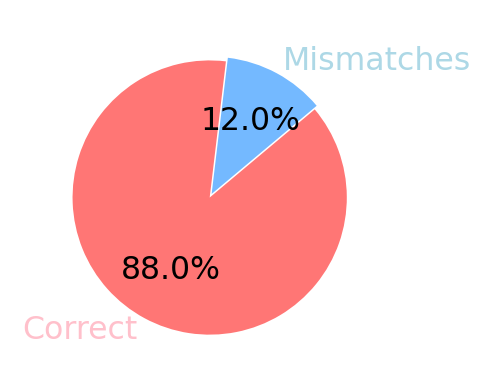

In [176]:
pie_chart(res_df, mismatches)

# Content-Based Features 

### Can we get the number of times a word appears in spam tweet?

then we can decide if the tweet is spam if more words are spam

In [177]:
vocab = vocab.set_index('WORD_ID')
vocab

,VOCAB_WORD
WORD_ID,
0,http
1,trump
2,news
3,get
4,new
...,...
2495,moto
2496,yell
2497,butter


In [178]:
''' this is just to get the words from the sparse matrix by tweet_id '''

def get_sparse_rows(grouped_data, idx):
    res = []
    for row in grouped_data:
        if row[0] == str(idx):
            res.append([row])
            res[-1].append(vocab.iloc[int(row[1])][0])
    return res

In [179]:
#get_sparse_rows(grouped_data, four_samples.index[0])

## Loading text and converting to dictionary

In [180]:
ham_words_stemmed_freqs_list = np.loadtxt('ham_words_stemmed.txt', delimiter=' ', dtype=str)
spam_words_stemmed_freqs_list = np.loadtxt('spam_words_stemmed.txt', delimiter=' ', dtype=str)

# convert to dictionary
ham_words_stemmed_freqs = {}
for pair in ham_words_stemmed_freqs_list:
    ham_words_stemmed_freqs[pair[0]] = pair[1]

spam_words_stemmed_freqs = {}
for pair in spam_words_stemmed_freqs_list:
    spam_words_stemmed_freqs[pair[0]] = pair[1]   

In [181]:
''' Method tokenizes, removes punctuation, removes stop words, and stems'''
def clean_tweet(message, stemmer=PorterStemmer(), stem=False,
                stop_words=set(stopwords.words('english'))):
    words = word_tokenize(message.lower())
    if stem:
        return reduce(lambda a,b: a + [stemmer.stem(b)] if b not in stop_words and b.isalpha() else a, words, [])
    else:
        return reduce(lambda a,b: a + [b] if b not in stop_words and b.isalpha() else a, words, [])

## Now We Can Make a New Tree That Compares Frequencies

In [182]:
''' Testing Dict of Word Frequencies '''

sample_tokens = clean_tweet(data.iloc[0].Tweet, stem=True)
print(sample_tokens)
print('num ham', ham_words_stemmed_freqs['good'])
print('num spam', spam_words_stemmed_freqs['good'])

['good', 'morn', 'love']
num ham 177
num spam 91


In [183]:
''' 
Function that gets Num URL's in a tweet
'''

def num_URLs(row):
    # tokenize tweet
    
    tokens = clean_tweet(row.Tweet, stem=True)
    res = 0
    
    for token in tokens:
        if token == 'http':
            res += 1
        if token == 'https':
            res += 1
    
    return res

In [184]:
i = 5
print(data.iloc[i].Tweet)
print(clean_tweet(data.iloc[i].Tweet))
num_URLs(data.iloc[i])


#amms Samantha Bee Tries to ATTACK Trump, Instead Insults Millions of Americans https://t.co/YcGbUqjpzY #amis https://t.co/ngYzOjidr9
['amms', 'samantha', 'bee', 'tries', 'attack', 'trump', 'instead', 'insults', 'millions', 'americans', 'https', 'amis', 'https']


2

In [185]:
''' 
tree0 - Uses frequency of word appears in spam tweet versus a ham tweet

    returns freq spam > freq ham (true = it is a spam tweet)
'''

def tree0(row):
    # tokenize the tweet
    tokens = clean_tweet(row.Tweet, stem=True)
    
    # tally the frequencies of all the words
    # sum them together and compare
    sum_spam = 0
    sum_ham = 0
    
    for token in tokens:
        if token in spam_words_stemmed_freqs:
            sum_spam += int(spam_words_stemmed_freqs[token])
        if token in ham_words_stemmed_freqs:
            sum_ham += int(ham_words_stemmed_freqs[token])
    #print(sum_spam)
    #print(sum_ham)
    
    return sum_spam > sum_ham

tree6(data.iloc[0])

True

In [186]:
'''
tree7 - returns False if more than 1 URLs in the tweet
'''

def tree7(row):
    if num_URLs(row) > 1: return True

## array of Trees (array of functions)

In [188]:
# Trees into an array, they all accept a row
trees = [tree0, tree1, tree2, tree3, tree4, tree5, tree6, tree7]

# Random Forest Algorithm

In [189]:
res_df = random_forest(subset_data, trees)

## Check results against actual data classificaitons

In [190]:
mismatches = get_mismatches(res_df)

num mismatches: 6
total samples: 50
percent right: 0.88


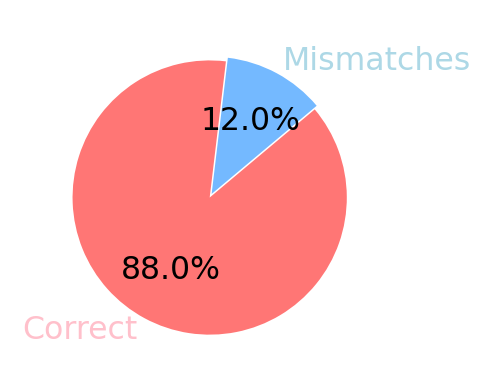

In [191]:
pie_chart(res_df, mismatches)

# Which tweets are getting classified wrong?

In [192]:
res_df[res_df.Classification != res_df.Actual]

,id,Tweet,Spam Count,Ham Count,Classification,Actual
4,9934,@SuzuyaReiXIII @NanaMuiToLoko @imogira1 @AllLo...,5,3,Spam,Ham
12,1454,THIS SONG IS THE REASON I HAVE SUCH HIGH STAND...,5,3,Spam,Ham
34,8961,#ste HIGH DRAMA : Scaramucci Points Finger at ...,4,4,Ham,Spam
38,3973,cashier: how are u\nme: good\n*comes back 3 ho...,5,3,Spam,Ham
41,8298,#acapa Birmingham Mayor SUED for CAVING to Lib...,3,5,Ham,Spam
49,7846,So grateful for so many things right now.,5,3,Spam,Ham


In [193]:
data.iloc[res_df.iloc[0].id]

Tweet         @abyvss \nWhy is govt. ignoring innocent Asara...
following                                                   0.0
followers                                                   0.0
actions                                                    20.0
is_retweet                                                  0.0
location                                                    NaN
Type                                                    Quality
Unnamed: 7                                                  NaN
Name: 12344, dtype: object

In [194]:
data.iloc[res_df.iloc[0].id].Tweet

"@abyvss \nWhy is govt. ignoring innocent Asaram Bapu Ji's Health? #WhyMediaHidesFactspic.twitter.com/DvRV1eeYwV"

In [195]:
for i, tree in enumerate(trees):
    print('tree', i, tree(data.iloc[res_df.iloc[0].id]))

tree 0 True
tree 1 False
tree 2 False
tree 3 False
tree 4 False
tree 5 True
tree 6 True
tree 7 None


In [196]:
tree1(data.iloc[1972])

False

# TODO run results across entire dataset to showcase results

In [ ]:
# Running Random Forest on all the data